In [1]:
import torch    
torch.manual_seed(123)
import random
random.seed(123)

import torch.nn as nn
import os
import shutil
import itertools

from chofer_torchex.utils.data.collate import dict_sample_target_iter_concat
from chofer_torchex.utils.functional import collection_cascade, cuda_cascade
from chofer_tda_datasets import Reddit5kJmlr
from chofer_tda_datasets.transforms import Hdf5GroupToDict
from jmlr_2018_code.utils import *
from sklearn.model_selection import ShuffleSplit

from chofer_torchex.nn.slayer import SLayerRationalHat, LinearRationalStretchedBirthLifeTimeCoordinateTransform, prepare_batch


from collections import Counter, defaultdict

%matplotlib notebook



from torch.utils.data import DataLoader

os.environ['CUDA_VISIBLE_DEVICES'] = str(0)

class RedditCollate:   
    def __init__(self, dataset, cuda=True):
        self.cuda = cuda
        self.dataset = dataset
        
    def __call__(self, sample_target_iter):
        x, y = dict_sample_target_iter_concat(sample_target_iter)
        
        for k in self.dataset.keys_not_essential:
            batch_view = x[k]
            x[k] = prepare_batch(batch_view, 2)
            
        for k in self.dataset.keys_essential:
            batch_view = x[k]
            x[k] = prepare_batch(batch_view, 1)            

        y = torch.LongTensor(y)    

        if self.cuda:
            # Shifting the necessary parts of the prepared batch to the cuda
            x = {k: collection_cascade(v,
                                       lambda x: isinstance(x, tuple),
                                       lambda x: (x[0].cuda(), x[1].cuda(), x[2], x[3]))
                 for k, v in x.items()}

            y = y.cuda()
            

        return x, y
    

class train_env:
    n_epochs = 300
    lr_initial = 0.5
    lr_epoch_step = 20
    batch_size = 100
    train_size = 0.9
    nu = 0.01
    momentum = 0.9


/scratch2/chofer/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
dataset = Reddit5kJmlr(data_root_folder_path='/scratch2/chofer/jmlr2018_data/')
dataset.keys_essential = ('dim_0_ess', 'dim_1_ess')
dataset.keys_not_essential = ('dim_0',)
dataset.keys_of_interrest =  dataset.keys_essential + dataset.keys_not_essential

In [3]:
def unsqueeze_essentials(x):
    for k in dataset.keys_essential:
        if len(x[k]) > 0:
            x[k] = x[k].unsqueeze(1)
            
    return x

def coordinate_transform(x):
    t = LinearRationalStretchedBirthLifeTimeCoordinateTransform(nu=train_env.nu)
    for k in dataset.keys_not_essential:
        x[k] = t(x[k])   
        
    return x

dataset.data_transforms = \
[
    Hdf5GroupToDict(),
    numpy_to_torch_cascade,
    coordinate_transform, 
    unsqueeze_essentials
]
dataset.target_transforms = [lambda x: int(x) - 1]

In [4]:
reddit_collate = RedditCollate(dataset, cuda=False)         

In [5]:
def LinearCell(n_in, n_out):
    m = nn.Sequential(nn.Linear(n_in, n_out), 
                      nn.BatchNorm1d(n_out), 
                      nn.ReLU()
                     )
    m.out_features = m[0].out_features
    return m


def Slayer(n_elements, point_dim):
    return SLayerRationalHat(n_elements, point_dimension=2, radius_init=500)   


class Reddit5KModel(nn.Module):    
    def __init__(self):
        super().__init__()  
        
        dim_0_n_elements = 150
#         dim_0_ess_n_elements = 5
#         dim_1_ess_n_elements = 50
        
        self.dim_0 = nn.Sequential(
            Slayer(dim_0_n_elements, 2),
            nn.Tanh()
        )
#         self.dim_0_ess = nn.Sequential(            
#             Slayer(dim_0_ess_n_elements, 1),
#             nn.Tanh()
#         )
#         self.dim_1_ess = nn.Sequential(            
#             Slayer(dim_1_ess_n_elements, 1),
#             nn.Tanh()
#         )
        

        cls_in_size = dim_0_n_elements  #+ dim_0_ess_n_elements + dim_1_ess_n_elements
        n_1 = 2*cls_in_size#int(cls_in_size/2)
#         cls_in_size = self.dim_0_linear.out_features + self.dim_0_ess_linear.out_features + self.dim_1_ess_linear.out_features
        self.cls = nn.Sequential(          
                               nn.Dropout(0.2),
                               LinearCell(cls_in_size, n_1),
                               nn.Dropout(0.2),
                               LinearCell(n_1, int(n_1/4)),
                               LinearCell(int(n_1/4), int(n_1/16)),
                               nn.Linear(int(n_1/16), 5))
                         
    def forward(self, x):
        x_dim_0 = self.dim_0(x['dim_0'])        
        
#         x_dim_0_ess = self.dim_0_ess(x['dim_0_ess'])   
        
#         x_dim_1_ess = self.dim_1_ess(x['dim_1_ess'])       
        
#         x = torch.cat([x_dim_0, x_dim_0_ess, x_dim_1_ess], dim=1)

        x = x_dim_0
        x = self.cls(x)
            
        return x
        
        
    def centers_init(self, sample_target_iter):
        x, _ = dict_sample_target_iter_concat(sample_target_iter)
        
        def get_centers(samples, n_centers):    
            s = torch.cat(samples, dim=0)
            s = list({tuple(row) for row in s})
            print(len(s))
            
            if len(s) < n_centers:
                while len(s) < n_centers:
                    s += s 
                    
            s = np.array(s)
            
            if s.ndim == 1:
                s = s.reshape(-1, 1)
                
            kmeans = sklearn.cluster.KMeans(n_clusters=n_centers, 
                                            init='k-means++', 
                                            random_state=123, 
                                            n_init=1)                           
            kmeans.fit(s)
            centers = kmeans.cluster_centers_
            centers = torch.from_numpy(centers).float()    
            return centers
        
        for key, slayer in zip(['dim_0', 
#                                 'dim_0_ess', 'dim_1_ess'
                               ], 
                               [self.dim_0[0], 
#                                 self.dim_0_ess[0], self.dim_1_ess[0]
                               ]):
            samples = x[key]       
            
            centers = get_centers(samples, slayer.centers.size(0))
            slayer.centers.data = centers

In [6]:
stats_of_runs = []
def experiment():      
    splitter = ShuffleSplit(n_splits=10, 
                            train_size=train_env.train_size, 
                            test_size=1-train_env.train_size, 
                            random_state=123)
    train_test_splits = list(splitter.split(X=dataset.targets, y=dataset.targets))

    train_test_splits = [(train_i.tolist(), test_i.tolist()) for train_i, test_i in train_test_splits]
    
    for run_i, (train_i, test_i) in enumerate(train_test_splits):
        print('')
        print('Run', run_i)
        
        model = Reddit5KModel()
        model.centers_init([dataset[i] for i in train_i])
        model.cuda()

        stats = defaultdict(list)
        stats_of_runs.append(stats)  
        
        stats['model'] = model        
        
        opt=torch.optim.SGD(model.parameters(), lr=train_env.lr_initial, momentum=train_env.momentum)

        for i_epoch in range(1, train_env.n_epochs+1):      

            model.train()

            train_sampler = [i for i in train_i] 
            random.shuffle(train_sampler)    
            
            dl_train = DataLoader(dataset,
                              batch_size=train_env.batch_size, 
                              collate_fn=reddit_collate,
                              sampler=train_sampler,                               
                              num_workers=0,
                              drop_last=True)

            dl_test = DataLoader(dataset,
                                 batch_size=train_env.batch_size, 
                                 collate_fn=reddit_collate, 
                                 sampler=test_i,
                                 num_workers=0)

            epoch_loss = 0

            if i_epoch % train_env.lr_epoch_step == 0:
                adapt_lr(opt, lambda lr: lr*0.5)

            for i_batch, (x, y) in enumerate(dl_train, 1):   
                
                x = {k: collection_cascade(v,
                                       lambda x: isinstance(x, tuple),
                                       lambda x: (x[0].cuda(), x[1].cuda(), x[2], x[3]))
                     for k, v in x.items()}

                y = y.cuda()

                y = torch.autograd.Variable(y)

                def closure():
                    opt.zero_grad()
                    y_hat = model(x)            
                    loss = nn.functional.cross_entropy(y_hat, y)   
                    loss.backward()
                    return loss

                loss = opt.step(closure)

                epoch_loss += float(loss)
                stats['loss_by_batch'].append(float(loss))
                stats['centers'].append(model.dim_0[0].centers.data.cpu().numpy())
                stats['radius'].append(model.dim_0[0].radius.data.cpu().numpy())

                print("Epoch {}/{}, Batch {}/{}".format(i_epoch, train_env.n_epochs, i_batch, len(dl_train)), end="       \r")

            stats['train_loss_by_epoch'].append(epoch_loss/len(dl_train))

            print("\n\r testing...")
            model.eval()    
            true_samples = 0
            seen_samples = 0
            epoch_test_loss = 0
            for i_batch, (x, y) in enumerate(dl_test):
                
                x = {k: collection_cascade(v,
                                       lambda x: isinstance(x, tuple),
                                       lambda x: (x[0].cuda(), x[1].cuda(), x[2], x[3]))
                 for k, v in x.items()}

                y = y.cuda()

                y_hat = model(x)
                epoch_test_loss += float(nn.functional.cross_entropy(y_hat, torch.autograd.Variable(y.cuda())).data)

                y_hat = y_hat.max(dim=1)[1].data.long()

                true_samples += (y_hat == y).sum()
                seen_samples += y.size(0)  

            stats['test_accuracy'].append(true_samples/seen_samples)
            stats['test_loss_by_epoch'].append(epoch_test_loss/len(dl_test))
            print(true_samples/seen_samples)       
        
experiment()        


Run 0
1492
Epoch 1/300, Batch 44/44       
 testing...
0.404
Epoch 2/300, Batch 44/44       
 testing...
0.392
Epoch 3/300, Batch 44/44       
 testing...
0.412
Epoch 4/300, Batch 44/44       
 testing...
0.374
Epoch 5/300, Batch 44/44       
 testing...
0.45
Epoch 6/300, Batch 44/44       
 testing...
0.448
Epoch 7/300, Batch 44/44       
 testing...
0.39
Epoch 8/300, Batch 44/44       
 testing...
0.406
Epoch 9/300, Batch 44/44       
 testing...
0.446
Epoch 10/300, Batch 44/44       
 testing...
0.432
Epoch 11/300, Batch 44/44       
 testing...
0.428
Epoch 12/300, Batch 44/44       
 testing...
0.398
Epoch 13/300, Batch 44/44       
 testing...
0.392
Epoch 14/300, Batch 44/44       
 testing...
0.404
Epoch 15/300, Batch 44/44       
 testing...
0.442
Epoch 16/300, Batch 44/44       
 testing...
0.428
Epoch 17/300, Batch 44/44       
 testing...
0.436
Epoch 18/300, Batch 44/44       
 testing...
0.418
Epoch 19/300, Batch 44/44       
 testing...
0.412
Epoch 20/300, Batch 44/44     

Epoch 161/300, Batch 44/44       
 testing...
0.444
Epoch 162/300, Batch 44/44       
 testing...
0.444
Epoch 163/300, Batch 44/44       
 testing...
0.448
Epoch 164/300, Batch 44/44       
 testing...
0.446
Epoch 165/300, Batch 44/44       
 testing...
0.442
Epoch 166/300, Batch 44/44       
 testing...
0.442
Epoch 167/300, Batch 44/44       
 testing...
0.44
Epoch 168/300, Batch 44/44       
 testing...
0.446
Epoch 169/300, Batch 44/44       
 testing...
0.436
Epoch 170/300, Batch 44/44       
 testing...
0.448
Epoch 171/300, Batch 44/44       
 testing...
0.448
Epoch 172/300, Batch 44/44       
 testing...
0.45
Epoch 173/300, Batch 44/44       
 testing...
0.438
Epoch 174/300, Batch 44/44       
 testing...
0.448
Epoch 175/300, Batch 44/44       
 testing...
0.446
Epoch 176/300, Batch 44/44       
 testing...
0.444
Epoch 177/300, Batch 44/44       
 testing...
0.44
Epoch 178/300, Batch 44/44       
 testing...
0.44
Epoch 179/300, Batch 44/44       
 testing...
0.442
Epoch 180/300, B

Epoch 19/300, Batch 44/44       
 testing...
0.444
Epoch 20/300, Batch 44/44       
 testing...
0.444
Epoch 21/300, Batch 44/44       
 testing...
0.414
Epoch 22/300, Batch 44/44       
 testing...
0.424
Epoch 23/300, Batch 44/44       
 testing...
0.456
Epoch 24/300, Batch 44/44       
 testing...
0.434
Epoch 25/300, Batch 44/44       
 testing...
0.418
Epoch 26/300, Batch 44/44       
 testing...
0.438
Epoch 27/300, Batch 44/44       
 testing...
0.41
Epoch 28/300, Batch 44/44       
 testing...
0.436
Epoch 29/300, Batch 44/44       
 testing...
0.426
Epoch 30/300, Batch 44/44       
 testing...
0.44
Epoch 31/300, Batch 44/44       
 testing...
0.4
Epoch 32/300, Batch 44/44       
 testing...
0.43
Epoch 33/300, Batch 44/44       
 testing...
0.458
Epoch 34/300, Batch 44/44       
 testing...
0.426
Epoch 35/300, Batch 44/44       
 testing...
0.412
Epoch 36/300, Batch 44/44       
 testing...
0.408
Epoch 37/300, Batch 44/44       
 testing...
0.408
Epoch 38/300, Batch 44/44       
 te

0.444
Epoch 179/300, Batch 44/44       
 testing...
0.448
Epoch 180/300, Batch 44/44       
 testing...
0.444
Epoch 181/300, Batch 44/44       
 testing...
0.448
Epoch 182/300, Batch 44/44       
 testing...
0.444
Epoch 183/300, Batch 44/44       
 testing...
0.446
Epoch 184/300, Batch 44/44       
 testing...
0.45
Epoch 185/300, Batch 44/44       
 testing...
0.438
Epoch 186/300, Batch 44/44       
 testing...
0.448
Epoch 187/300, Batch 44/44       
 testing...
0.446
Epoch 188/300, Batch 44/44       
 testing...
0.45
Epoch 189/300, Batch 44/44       
 testing...
0.448
Epoch 190/300, Batch 44/44       
 testing...
0.448
Epoch 191/300, Batch 44/44       
 testing...
0.45
Epoch 192/300, Batch 44/44       
 testing...
0.448
Epoch 193/300, Batch 44/44       
 testing...
0.448
Epoch 194/300, Batch 44/44       
 testing...
0.446
Epoch 195/300, Batch 44/44       
 testing...
0.446
Epoch 196/300, Batch 44/44       
 testing...
0.45
Epoch 197/300, Batch 44/44       
 testing...
0.452
Epoch 198/

Epoch 37/300, Batch 44/44       
 testing...
0.438
Epoch 38/300, Batch 44/44       
 testing...
0.46
Epoch 39/300, Batch 44/44       
 testing...
0.436
Epoch 40/300, Batch 44/44       
 testing...
0.44
Epoch 41/300, Batch 44/44       
 testing...
0.464
Epoch 42/300, Batch 44/44       
 testing...
0.434
Epoch 43/300, Batch 44/44       
 testing...
0.436
Epoch 44/300, Batch 44/44       
 testing...
0.458
Epoch 45/300, Batch 44/44       
 testing...
0.444
Epoch 46/300, Batch 44/44       
 testing...
0.468
Epoch 47/300, Batch 44/44       
 testing...
0.452
Epoch 48/300, Batch 44/44       
 testing...
0.458
Epoch 49/300, Batch 44/44       
 testing...
0.436
Epoch 50/300, Batch 44/44       
 testing...
0.454
Epoch 51/300, Batch 44/44       
 testing...
0.434
Epoch 52/300, Batch 44/44       
 testing...
0.452
Epoch 53/300, Batch 44/44       
 testing...
0.424
Epoch 54/300, Batch 44/44       
 testing...
0.456
Epoch 55/300, Batch 44/44       
 testing...
0.448
Epoch 56/300, Batch 44/44       


Epoch 196/300, Batch 44/44       
 testing...
0.444
Epoch 197/300, Batch 44/44       
 testing...
0.444
Epoch 198/300, Batch 44/44       
 testing...
0.438
Epoch 199/300, Batch 44/44       
 testing...
0.442
Epoch 200/300, Batch 44/44       
 testing...
0.448
Epoch 201/300, Batch 44/44       
 testing...
0.44
Epoch 202/300, Batch 44/44       
 testing...
0.44
Epoch 203/300, Batch 44/44       
 testing...
0.448
Epoch 204/300, Batch 44/44       
 testing...
0.44
Epoch 205/300, Batch 44/44       
 testing...
0.438
Epoch 206/300, Batch 44/44       
 testing...
0.442
Epoch 207/300, Batch 44/44       
 testing...
0.444
Epoch 208/300, Batch 44/44       
 testing...
0.44
Epoch 209/300, Batch 44/44       
 testing...
0.44
Epoch 210/300, Batch 44/44       
 testing...
0.448
Epoch 211/300, Batch 44/44       
 testing...
0.442
Epoch 212/300, Batch 44/44       
 testing...
0.44
Epoch 213/300, Batch 44/44       
 testing...
0.44
Epoch 214/300, Batch 44/44       
 testing...
0.44
Epoch 215/300, Batch

Epoch 55/300, Batch 44/44       
 testing...
0.428
Epoch 56/300, Batch 44/44       
 testing...
0.46
Epoch 57/300, Batch 44/44       
 testing...
0.468
Epoch 58/300, Batch 44/44       
 testing...
0.458
Epoch 59/300, Batch 44/44       
 testing...
0.44
Epoch 60/300, Batch 44/44       
 testing...
0.446
Epoch 61/300, Batch 44/44       
 testing...
0.456
Epoch 62/300, Batch 44/44       
 testing...
0.464
Epoch 63/300, Batch 44/44       
 testing...
0.44
Epoch 64/300, Batch 44/44       
 testing...
0.44
Epoch 65/300, Batch 44/44       
 testing...
0.458
Epoch 66/300, Batch 44/44       
 testing...
0.45
Epoch 67/300, Batch 44/44       
 testing...
0.458
Epoch 68/300, Batch 44/44       
 testing...
0.422
Epoch 69/300, Batch 44/44       
 testing...
0.454
Epoch 70/300, Batch 44/44       
 testing...
0.466
Epoch 71/300, Batch 44/44       
 testing...
0.45
Epoch 72/300, Batch 44/44       
 testing...
0.44
Epoch 73/300, Batch 44/44       
 testing...
0.452
Epoch 74/300, Batch 44/44       
 test

Epoch 214/300, Batch 44/44       
 testing...
0.444
Epoch 215/300, Batch 44/44       
 testing...
0.446
Epoch 216/300, Batch 44/44       
 testing...
0.444
Epoch 217/300, Batch 44/44       
 testing...
0.436
Epoch 218/300, Batch 44/44       
 testing...
0.434
Epoch 219/300, Batch 44/44       
 testing...
0.44
Epoch 220/300, Batch 44/44       
 testing...
0.45
Epoch 221/300, Batch 44/44       
 testing...
0.448
Epoch 222/300, Batch 44/44       
 testing...
0.45
Epoch 223/300, Batch 44/44       
 testing...
0.444
Epoch 224/300, Batch 44/44       
 testing...
0.45
Epoch 225/300, Batch 44/44       
 testing...
0.452
Epoch 226/300, Batch 44/44       
 testing...
0.438
Epoch 227/300, Batch 44/44       
 testing...
0.444
Epoch 228/300, Batch 44/44       
 testing...
0.448
Epoch 229/300, Batch 44/44       
 testing...
0.45
Epoch 230/300, Batch 44/44       
 testing...
0.45
Epoch 231/300, Batch 44/44       
 testing...
0.438
Epoch 232/300, Batch 44/44       
 testing...
0.438
Epoch 233/300, Bat

Epoch 73/300, Batch 44/44       
 testing...
0.418
Epoch 74/300, Batch 44/44       
 testing...
0.422
Epoch 75/300, Batch 44/44       
 testing...
0.412
Epoch 76/300, Batch 44/44       
 testing...
0.41
Epoch 77/300, Batch 44/44       
 testing...
0.422
Epoch 78/300, Batch 44/44       
 testing...
0.412
Epoch 79/300, Batch 44/44       
 testing...
0.414
Epoch 80/300, Batch 44/44       
 testing...
0.41
Epoch 81/300, Batch 44/44       
 testing...
0.424
Epoch 82/300, Batch 44/44       
 testing...
0.414
Epoch 83/300, Batch 44/44       
 testing...
0.414
Epoch 84/300, Batch 44/44       
 testing...
0.424
Epoch 85/300, Batch 44/44       
 testing...
0.418
Epoch 86/300, Batch 44/44       
 testing...
0.408
Epoch 87/300, Batch 44/44       
 testing...
0.424
Epoch 88/300, Batch 44/44       
 testing...
0.408
Epoch 89/300, Batch 44/44       
 testing...
0.42
Epoch 90/300, Batch 44/44       
 testing...
0.43
Epoch 91/300, Batch 44/44       
 testing...
0.424
Epoch 92/300, Batch 44/44       
 t

Epoch 231/300, Batch 44/44       
 testing...
0.414
Epoch 232/300, Batch 44/44       
 testing...
0.422
Epoch 233/300, Batch 44/44       
 testing...
0.422
Epoch 234/300, Batch 44/44       
 testing...
0.418
Epoch 235/300, Batch 44/44       
 testing...
0.42
Epoch 236/300, Batch 44/44       
 testing...
0.416
Epoch 237/300, Batch 44/44       
 testing...
0.412
Epoch 238/300, Batch 44/44       
 testing...
0.412
Epoch 239/300, Batch 44/44       
 testing...
0.412
Epoch 240/300, Batch 44/44       
 testing...
0.416
Epoch 241/300, Batch 44/44       
 testing...
0.422
Epoch 242/300, Batch 44/44       
 testing...
0.418
Epoch 243/300, Batch 44/44       
 testing...
0.41
Epoch 244/300, Batch 44/44       
 testing...
0.418
Epoch 245/300, Batch 44/44       
 testing...
0.42
Epoch 246/300, Batch 44/44       
 testing...
0.418
Epoch 247/300, Batch 44/44       
 testing...
0.418
Epoch 248/300, Batch 44/44       
 testing...
0.418
Epoch 249/300, Batch 44/44       
 testing...
0.422
Epoch 250/300, 

0.448
Epoch 91/300, Batch 44/44       
 testing...
0.462
Epoch 92/300, Batch 44/44       
 testing...
0.464
Epoch 93/300, Batch 44/44       
 testing...
0.466
Epoch 94/300, Batch 44/44       
 testing...
0.468
Epoch 95/300, Batch 44/44       
 testing...
0.474
Epoch 96/300, Batch 44/44       
 testing...
0.454
Epoch 97/300, Batch 44/44       
 testing...
0.47
Epoch 98/300, Batch 44/44       
 testing...
0.458
Epoch 99/300, Batch 44/44       
 testing...
0.46
Epoch 100/300, Batch 44/44       
 testing...
0.46
Epoch 101/300, Batch 44/44       
 testing...
0.466
Epoch 102/300, Batch 44/44       
 testing...
0.46
Epoch 103/300, Batch 44/44       
 testing...
0.468
Epoch 104/300, Batch 44/44       
 testing...
0.464
Epoch 105/300, Batch 44/44       
 testing...
0.464
Epoch 106/300, Batch 44/44       
 testing...
0.46
Epoch 107/300, Batch 44/44       
 testing...
0.464
Epoch 108/300, Batch 44/44       
 testing...
0.466
Epoch 109/300, Batch 44/44       
 testing...
0.468
Epoch 110/300, Batch

Epoch 249/300, Batch 44/44       
 testing...
0.464
Epoch 250/300, Batch 44/44       
 testing...
0.466
Epoch 251/300, Batch 44/44       
 testing...
0.464
Epoch 252/300, Batch 44/44       
 testing...
0.46
Epoch 253/300, Batch 44/44       
 testing...
0.464
Epoch 254/300, Batch 44/44       
 testing...
0.466
Epoch 255/300, Batch 44/44       
 testing...
0.468
Epoch 256/300, Batch 44/44       
 testing...
0.466
Epoch 257/300, Batch 44/44       
 testing...
0.462
Epoch 258/300, Batch 44/44       
 testing...
0.458
Epoch 259/300, Batch 44/44       
 testing...
0.458
Epoch 260/300, Batch 44/44       
 testing...
0.464
Epoch 261/300, Batch 44/44       
 testing...
0.454
Epoch 262/300, Batch 44/44       
 testing...
0.46
Epoch 263/300, Batch 44/44       
 testing...
0.464
Epoch 264/300, Batch 44/44       
 testing...
0.462
Epoch 265/300, Batch 44/44       
 testing...
0.464
Epoch 266/300, Batch 44/44       
 testing...
0.458
Epoch 267/300, Batch 44/44       
 testing...
0.47
Epoch 268/300, 

Epoch 109/300, Batch 44/44       
 testing...
0.448
Epoch 110/300, Batch 44/44       
 testing...
0.444
Epoch 111/300, Batch 44/44       
 testing...
0.446
Epoch 112/300, Batch 44/44       
 testing...
0.448
Epoch 113/300, Batch 44/44       
 testing...
0.45
Epoch 114/300, Batch 44/44       
 testing...
0.448
Epoch 115/300, Batch 44/44       
 testing...
0.44
Epoch 116/300, Batch 44/44       
 testing...
0.448
Epoch 117/300, Batch 44/44       
 testing...
0.45
Epoch 118/300, Batch 44/44       
 testing...
0.442
Epoch 119/300, Batch 44/44       
 testing...
0.446
Epoch 120/300, Batch 44/44       
 testing...
0.45
Epoch 121/300, Batch 44/44       
 testing...
0.45
Epoch 122/300, Batch 44/44       
 testing...
0.448
Epoch 123/300, Batch 44/44       
 testing...
0.442
Epoch 124/300, Batch 44/44       
 testing...
0.442
Epoch 125/300, Batch 44/44       
 testing...
0.446
Epoch 126/300, Batch 44/44       
 testing...
0.446
Epoch 127/300, Batch 44/44       
 testing...
0.448
Epoch 128/300, Ba

Epoch 267/300, Batch 44/44       
 testing...
0.442
Epoch 268/300, Batch 44/44       
 testing...
0.45
Epoch 269/300, Batch 44/44       
 testing...
0.442
Epoch 270/300, Batch 44/44       
 testing...
0.44
Epoch 271/300, Batch 44/44       
 testing...
0.44
Epoch 272/300, Batch 44/44       
 testing...
0.436
Epoch 273/300, Batch 44/44       
 testing...
0.444
Epoch 274/300, Batch 44/44       
 testing...
0.442
Epoch 275/300, Batch 44/44       
 testing...
0.446
Epoch 276/300, Batch 44/44       
 testing...
0.444
Epoch 277/300, Batch 44/44       
 testing...
0.446
Epoch 278/300, Batch 44/44       
 testing...
0.442
Epoch 279/300, Batch 44/44       
 testing...
0.444
Epoch 280/300, Batch 44/44       
 testing...
0.446
Epoch 281/300, Batch 44/44       
 testing...
0.446
Epoch 282/300, Batch 44/44       
 testing...
0.446
Epoch 283/300, Batch 44/44       
 testing...
0.442
Epoch 284/300, Batch 44/44       
 testing...
0.446
Epoch 285/300, Batch 44/44       
 testing...
0.444
Epoch 286/300, 

Epoch 127/300, Batch 44/44       
 testing...
0.474
Epoch 128/300, Batch 44/44       
 testing...
0.474
Epoch 129/300, Batch 44/44       
 testing...
0.478
Epoch 130/300, Batch 44/44       
 testing...
0.478
Epoch 131/300, Batch 44/44       
 testing...
0.472
Epoch 132/300, Batch 44/44       
 testing...
0.48
Epoch 133/300, Batch 44/44       
 testing...
0.474
Epoch 134/300, Batch 44/44       
 testing...
0.472
Epoch 135/300, Batch 44/44       
 testing...
0.478
Epoch 136/300, Batch 44/44       
 testing...
0.478
Epoch 137/300, Batch 44/44       
 testing...
0.476
Epoch 138/300, Batch 44/44       
 testing...
0.476
Epoch 139/300, Batch 44/44       
 testing...
0.476
Epoch 140/300, Batch 44/44       
 testing...
0.478
Epoch 141/300, Batch 44/44       
 testing...
0.48
Epoch 142/300, Batch 44/44       
 testing...
0.47
Epoch 143/300, Batch 44/44       
 testing...
0.474
Epoch 144/300, Batch 44/44       
 testing...
0.476
Epoch 145/300, Batch 44/44       
 testing...
0.474
Epoch 146/300, 

Epoch 285/300, Batch 44/44       
 testing...
0.48
Epoch 286/300, Batch 44/44       
 testing...
0.472
Epoch 287/300, Batch 44/44       
 testing...
0.474
Epoch 288/300, Batch 44/44       
 testing...
0.48
Epoch 289/300, Batch 44/44       
 testing...
0.47
Epoch 290/300, Batch 44/44       
 testing...
0.47
Epoch 291/300, Batch 44/44       
 testing...
0.48
Epoch 292/300, Batch 44/44       
 testing...
0.474
Epoch 293/300, Batch 44/44       
 testing...
0.478
Epoch 294/300, Batch 44/44       
 testing...
0.47
Epoch 295/300, Batch 44/44       
 testing...
0.474
Epoch 296/300, Batch 44/44       
 testing...
0.476
Epoch 297/300, Batch 44/44       
 testing...
0.474
Epoch 298/300, Batch 44/44       
 testing...
0.474
Epoch 299/300, Batch 44/44       
 testing...
0.478
Epoch 300/300, Batch 44/44       
 testing...
0.474

Run 8
1487
Epoch 1/300, Batch 44/44       
 testing...
0.356
Epoch 2/300, Batch 44/44       
 testing...
0.416
Epoch 3/300, Batch 44/44       
 testing...
0.39
Epoch 4/300, 

Epoch 145/300, Batch 44/44       
 testing...
0.448
Epoch 146/300, Batch 44/44       
 testing...
0.442
Epoch 147/300, Batch 44/44       
 testing...
0.458
Epoch 148/300, Batch 44/44       
 testing...
0.438
Epoch 149/300, Batch 44/44       
 testing...
0.446
Epoch 150/300, Batch 44/44       
 testing...
0.448
Epoch 151/300, Batch 44/44       
 testing...
0.454
Epoch 152/300, Batch 44/44       
 testing...
0.438
Epoch 153/300, Batch 44/44       
 testing...
0.45
Epoch 154/300, Batch 44/44       
 testing...
0.446
Epoch 155/300, Batch 44/44       
 testing...
0.446
Epoch 156/300, Batch 44/44       
 testing...
0.446
Epoch 157/300, Batch 44/44       
 testing...
0.446
Epoch 158/300, Batch 44/44       
 testing...
0.438
Epoch 159/300, Batch 44/44       
 testing...
0.436
Epoch 160/300, Batch 44/44       
 testing...
0.444
Epoch 161/300, Batch 44/44       
 testing...
0.442
Epoch 162/300, Batch 44/44       
 testing...
0.444
Epoch 163/300, Batch 44/44       
 testing...
0.45
Epoch 164/300,

0.45
Epoch 3/300, Batch 44/44       
 testing...
0.318
Epoch 4/300, Batch 44/44       
 testing...
0.39
Epoch 5/300, Batch 44/44       
 testing...
0.424
Epoch 6/300, Batch 44/44       
 testing...
0.342
Epoch 7/300, Batch 44/44       
 testing...
0.43
Epoch 8/300, Batch 44/44       
 testing...
0.414
Epoch 9/300, Batch 44/44       
 testing...
0.386
Epoch 10/300, Batch 44/44       
 testing...
0.398
Epoch 11/300, Batch 44/44       
 testing...
0.402
Epoch 12/300, Batch 44/44       
 testing...
0.43
Epoch 13/300, Batch 44/44       
 testing...
0.408
Epoch 14/300, Batch 44/44       
 testing...
0.42
Epoch 15/300, Batch 44/44       
 testing...
0.422
Epoch 16/300, Batch 44/44       
 testing...
0.444
Epoch 17/300, Batch 44/44       
 testing...
0.45
Epoch 18/300, Batch 44/44       
 testing...
0.392
Epoch 19/300, Batch 44/44       
 testing...
0.422
Epoch 20/300, Batch 44/44       
 testing...
0.422
Epoch 21/300, Batch 44/44       
 testing...
0.434
Epoch 22/300, Batch 44/44       
 test

Epoch 163/300, Batch 44/44       
 testing...
0.43
Epoch 164/300, Batch 44/44       
 testing...
0.43
Epoch 165/300, Batch 44/44       
 testing...
0.422
Epoch 166/300, Batch 44/44       
 testing...
0.434
Epoch 167/300, Batch 44/44       
 testing...
0.432
Epoch 168/300, Batch 44/44       
 testing...
0.426
Epoch 169/300, Batch 44/44       
 testing...
0.434
Epoch 170/300, Batch 44/44       
 testing...
0.438
Epoch 171/300, Batch 44/44       
 testing...
0.434
Epoch 172/300, Batch 44/44       
 testing...
0.436
Epoch 173/300, Batch 44/44       
 testing...
0.432
Epoch 174/300, Batch 44/44       
 testing...
0.432
Epoch 175/300, Batch 44/44       
 testing...
0.436
Epoch 176/300, Batch 44/44       
 testing...
0.44
Epoch 177/300, Batch 44/44       
 testing...
0.436
Epoch 178/300, Batch 44/44       
 testing...
0.44
Epoch 179/300, Batch 44/44       
 testing...
0.43
Epoch 180/300, Batch 44/44       
 testing...
0.43
Epoch 181/300, Batch 44/44       
 testing...
0.43
Epoch 182/300, Batc

In [7]:
print(np.mean([np.mean(s['test_accuracy'][-10:]) for s in stats_of_runs]))
[np.mean(s['test_accuracy'][-10:]) for s in stats_of_runs]

0.44465999999999994


[0.4462,
 0.44580000000000003,
 0.441,
 0.4426,
 0.4136,
 0.4620000000000001,
 0.4438,
 0.47519999999999996,
 0.4426,
 0.4338]

In [ ]:
plt.figure()
stats = stats_of_runs[0]

c_start = stats['centers'][3]
c_end = stats['centers'][-1]

plt.plot(c_start[:,0], c_start[:, 1], 'bo', label='center initialization')
plt.plot(c_end[:,0], c_end[:, 1], 'ro', label='center learned')

all_centers = numpy.stack(stats['centers'], axis=0)
for i in range(all_centers.shape[1]):
    points = all_centers[:,i, :]
    plt.plot(points[:, 0], points[:, 1], '-k')
    
plt.legend()

plt.figure()
plt.plot(stats['train_loss_by_epoch'], label='train_loss')
plt.plot(stats['test_loss_by_epoch'], label='test_loss')
plt.plot(stats['test_accuracy'], label='test_acccuracy')
plt.legend()

plt.figure()
radius = stats['radius']
radius = np.stack(radius, axis=1)
for curve in radius:
    plt.plot(curve)
plt.show()

In [11]:
dgm_len_by_label_dim_0 = defaultdict(list)
dgm_len_by_label_dim_1 = defaultdict(list)

for x, y in dataset:
    l_0 = x['dim_0'].shape[0]
    l_1 = len(x['dim_1_ess'])
    dgm_len_by_label_dim_0[y].append(l_0)
    dgm_len_by_label_dim_1[y].append(l_1)
    

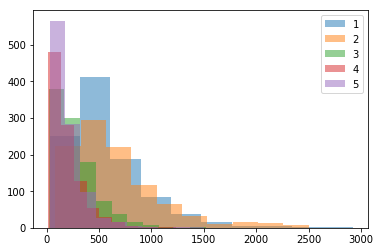

In [12]:
for k, v in sorted(dgm_len_by_label_dim_0.items(), key=lambda x: x[0]):
    plt.hist(v, label=str(k), alpha=0.5)
plt.legend()

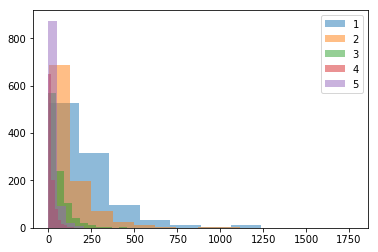

In [13]:
for k, v in sorted(dgm_len_by_label_dim_1.items(), key=lambda x: x[0]):
    plt.hist(v, label=str(k), alpha=0.5)
plt.legend()